利用TensorFlow2.0建立时间序列RNN模型，对国内的新冠肺炎疫情结束时间进行预测

一，准备数据

本文的数据集取自tushare，获取该数据集的方法参考了以下文章。

《https://zhuanlan.zhihu.com/p/109556102》

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import models,layers,losses,metrics,callbacks

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.]),
 <a list of 7 Text xticklabel objects>)

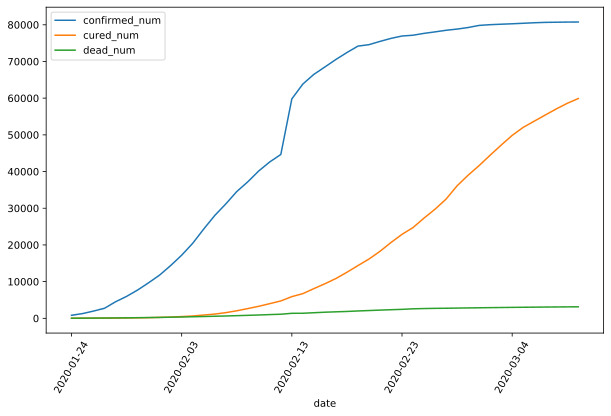

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

df = pd.read_csv("./data/covid-19.csv",sep = "\t")
df.plot(x = "date",y = ["confirmed_num","cured_num","dead_num"],figsize=(10,6))
plt.xticks(rotation=60)

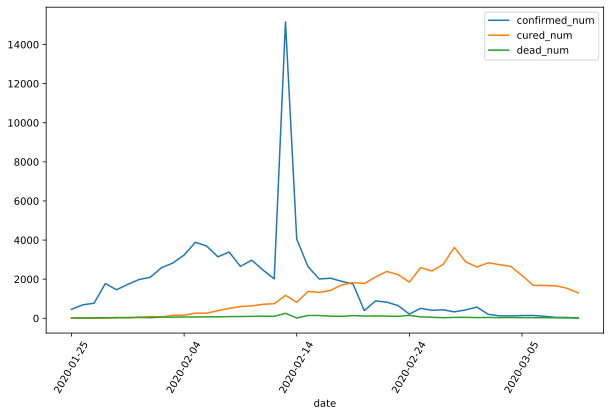

In [4]:
dfdata = df.set_index("date")
dfdiff = dfdata.diff(periods=1).dropna()
dfdiff = dfdiff.reset_index("date")

dfdiff.plot(x = "date",y = ["confirmed_num","cured_num","dead_num"],figsize=(10,6))
plt.xticks(rotation=60)
dfdiff = dfdiff.drop("date",axis = 1).astype("float32")

In [5]:
#用某日前8天窗口数据作为输入预测该日数据
WINDOW_SIZE = 8

def batch_dataset(dataset):
    dataset_batched = dataset.batch(WINDOW_SIZE,drop_remainder=True)
    return dataset_batched

ds_data = tf.data.Dataset.from_tensor_slices(tf.constant(dfdiff.values,dtype = tf.float32)) \
   .window(WINDOW_SIZE,shift=1).flat_map(batch_dataset)

ds_label = tf.data.Dataset.from_tensor_slices(
    tf.constant(dfdiff.values[WINDOW_SIZE:],dtype = tf.float32))

#数据较小，可以将全部训练数据放入到一个batch中，提升性能
ds_train = tf.data.Dataset.zip((ds_data,ds_label)).batch(38).cache()

二，定义模型

In [6]:
#考虑到新增确诊，新增治愈，新增死亡人数数据不可能小于0，设计如下结构
class Block(layers.Layer):
    def __init__(self, **kwargs):
        super(Block, self).__init__(**kwargs)

    def call(self, x_input,x):
        x_out = tf.maximum((1+x)*x_input[:,-1,:],0.0)
        return x_out

    def get_config(self):  
        config = super(Block, self).get_config()
        return config

In [7]:
tf.keras.backend.clear_session()
x_input = layers.Input(shape = (None,3),dtype = tf.float32)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x_input)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,input_shape=(None,3))(x)
x = layers.Dense(3)(x)

#考虑到新增确诊，新增治愈，新增死亡人数数据不可能小于0，设计如下结构
#x = tf.maximum((1+x)*x_input[:,-1,:],0.0)
x = Block()(x_input,x)
model = models.Model(inputs = [x_input],outputs = [x])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 3)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 3)           84        
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 3)           84        
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 3)           84        
_________________________________________________________________
lstm_3 (LSTM)                (None, 3)                 84        
_________________________________________________________________
dense (Dense)                (None, 3)                 12        
_________________________________________________________________
block (Block)                (None, 3)                 0     

三，训练模型

In [8]:
# 循环神经网络调试较为困难，需要设置多个不同的学习率多次尝试，以取得较好的效果
# 自定义损失函数，考虑平方差和预测目标的比值
class MSPE(losses.Loss):
    def call(self,y_true,y_pred):
        err_percent = (y_true - y_pred)**2/(tf.maximum(y_true**2,1e-7))
        mean_err_percent = tf.reduce_mean(err_percent)
        return mean_err_percent

    def get_config(self):
        config = super(MSPE, self).get_config()
        return config

In [10]:
import datetime

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer,loss=MSPE(name = "MSPE"))

logdir = ".\\data\\keras_model\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
#如果loss在100个epoch后没有提升，学习率减半。
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",factor = 0.5, patience = 100)
#当loss在200个epoch后没有提升，则提前终止训练。
stop_callback = tf.keras.callbacks.EarlyStopping(monitor = "loss", patience= 200)
callbacks_list = [tb_callback,lr_callback,stop_callback]

history = model.fit(ds_train,epochs=500,callbacks = callbacks_list)

Epoch 1/500
1/1 [==============================] - 5s 5s/step - loss: 3.3579
Epoch 2/500
1/1 [==============================] - 0s 32ms/step - loss: 3.1757
Epoch 3/500
1/1 [==============================] - 0s 20ms/step - loss: 2.9865
Epoch 4/500
1/1 [==============================] - 0s 19ms/step - loss: 2.7882
Epoch 5/500
1/1 [==============================] - 0s 20ms/step - loss: 2.5806
Epoch 6/500
1/1 [==============================] - 0s 20ms/step - loss: 2.3617
Epoch 7/500
1/1 [==============================] - 0s 19ms/step - loss: 2.1318
Epoch 8/500
1/1 [==============================] - 0s 19ms/step - loss: 1.8925
Epoch 9/500
1/1 [==============================] - 0s 20ms/step - loss: 1.6472
Epoch 10/500
1/1 [==============================] - 0s 19ms/step - loss: 1.4013
Epoch 11/500
1/1 [==============================] - 0s 19ms/step - loss: 1.1630
Epoch 12/500
1/1 [==============================] - 0s 19ms/step - loss: 0.9425
Epoch 13/500
1/1 [==============================] -

Epoch 104/500
1/1 [==============================] - 0s 20ms/step - loss: 0.4467
Epoch 105/500
1/1 [==============================] - 0s 20ms/step - loss: 0.4467
Epoch 106/500
1/1 [==============================] - 0s 19ms/step - loss: 0.4467
Epoch 107/500
1/1 [==============================] - 0s 19ms/step - loss: 0.4467
Epoch 108/500
1/1 [==============================] - 0s 19ms/step - loss: 0.4467
Epoch 109/500
1/1 [==============================] - 0s 20ms/step - loss: 0.4467
Epoch 110/500
1/1 [==============================] - 0s 21ms/step - loss: 0.4467
Epoch 111/500
1/1 [==============================] - 0s 19ms/step - loss: 0.4467
Epoch 112/500
1/1 [==============================] - 0s 20ms/step - loss: 0.4467
Epoch 113/500
1/1 [==============================] - 0s 20ms/step - loss: 0.4467
Epoch 114/500
1/1 [==============================] - 0s 20ms/step - loss: 0.4467
Epoch 115/500
1/1 [==============================] - 0s 20ms/step - loss: 0.4467
Epoch 116/500
1/1 [=========

Epoch 206/500
1/1 [==============================] - 0s 23ms/step - loss: 0.4466
Epoch 207/500
1/1 [==============================] - 0s 19ms/step - loss: 0.4466
Epoch 208/500
1/1 [==============================] - 0s 19ms/step - loss: 0.4466
Epoch 209/500
1/1 [==============================] - 0s 20ms/step - loss: 0.4466
Epoch 210/500
1/1 [==============================] - 0s 19ms/step - loss: 0.4466
Epoch 211/500
1/1 [==============================] - 0s 19ms/step - loss: 0.4466
Epoch 212/500
1/1 [==============================] - 0s 19ms/step - loss: 0.4466
Epoch 213/500
1/1 [==============================] - 0s 19ms/step - loss: 0.4466
Epoch 214/500
1/1 [==============================] - 0s 19ms/step - loss: 0.4466
Epoch 215/500
1/1 [==============================] - 0s 20ms/step - loss: 0.4466
Epoch 216/500
1/1 [==============================] - 0s 20ms/step - loss: 0.4466
Epoch 217/500
1/1 [==============================] - 0s 20ms/step - loss: 0.4466


四，评估模型

In [11]:
# 评估模型一般要设置验证集或者测试集，由于此例数据较少，我们仅仅可视化损失函数在训练集上的迭代情况。

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.title('Training '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric])
    plt.show()

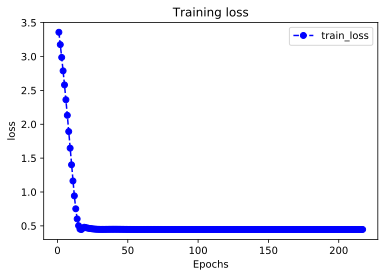

In [12]:
plot_metric(history,"loss")

五，使用模型

In [13]:
# 此处我们使用模型预测疫情结束时间，即 新增确诊病例为0 的时间。

#使用dfresult记录现有数据以及此后预测的疫情数据
dfresult = dfdiff[["confirmed_num","cured_num","dead_num"]].copy()
dfresult.tail()

,confirmed_num,cured_num,dead_num
41,143.0,1681.0,30.0
42,99.0,1678.0,28.0
43,44.0,1661.0,27.0
44,40.0,1535.0,22.0
45,19.0,1297.0,17.0


In [14]:
#预测此后100天的新增走势,将其结果添加到dfresult中
for i in range(100):
    arr_predict = model.predict(tf.constant(tf.expand_dims(dfresult.values[-38:,:],axis = 0)))

    dfpredict = pd.DataFrame(tf.cast(tf.floor(arr_predict),tf.float32).numpy(),
                columns = dfresult.columns)
    dfresult = dfresult.append(dfpredict,ignore_index=True)

In [15]:
dfresult.query("confirmed_num==0").head()

,confirmed_num,cured_num,dead_num
50,0.0,1237.0,0.0
51,0.0,1225.0,0.0
52,0.0,1213.0,0.0
53,0.0,1201.0,0.0
54,0.0,1190.0,0.0


In [16]:
dfresult.query("cured_num==0").head()

,confirmed_num,cured_num,dead_num


In [17]:
dfresult.query("dead_num==0").head()

,confirmed_num,cured_num,dead_num
46,9.0,1285.0,0.0
47,4.0,1273.0,0.0
48,2.0,1261.0,0.0
49,1.0,1249.0,0.0
50,0.0,1237.0,0.0


六，保存模型

In [18]:
model.save('./data/tf_model_savedmodel', save_format="tf")
print('export saved model.')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./data/tf_model_savedmodel\assets
export saved model.


In [19]:
model_loaded = tf.keras.models.load_model('./data/tf_model_savedmodel',compile=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_loaded.compile(optimizer=optimizer,loss=MSPE(name = "MSPE"))
model_loaded.predict(ds_train)

array([[1103.1836  ,   87.7547  ,    0.      ],
       [1360.7158  ,   68.80766 ,    0.      ],
       [1484.7517  ,  146.59024 ,    0.      ],
       [1699.1866  ,  156.56236 ,    0.      ],
       [2042.3876  ,  259.27527 ,    0.      ],
       [1941.477   ,  260.27246 ,    0.      ],
       [1651.8848  ,  385.92123 ,    0.      ],
       [1779.0741  ,  508.5784  ,    0.      ],
       [1393.827   ,  597.3303  ,    0.      ],
       [1562.5369  ,  630.23834 ,    0.      ],
       [1296.5956  ,  713.00696 ,    0.      ],
       [1059.0353  ,  741.92615 ,    0.      ],
       [7962.999   , 1167.7358  ,    0.      ],
       [2127.0054  ,  809.7366  ,    0.      ],
       [1388.0458  , 1369.1729  ,    0.      ],
       [1055.3562  , 1319.3121  ,    0.      ],
       [1076.3793  , 1421.0278  ,    0.      ],
       [ 992.2872  , 1703.239   ,    0.      ],
       [ 919.2321  , 1818.9156  ,    0.      ],
       [ 205.80515 , 1772.3353  ,    0.      ],
       [ 468.21204 , 2101.6453  ,    0. 